In [3]:
import os
import pickle
import gc
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory, Center
from openretina.utils.misc import CustomPrettyPrinter
from openretina.optimization.objective import SingleNeuronObjective, SliceMeanReducer
from openretina.optimization.optimizer import optimize_stimulus
from openretina.optimization.optimization_stopper import EarlyStopper
from openretina.optimization.regularizer import RangeRegularizationLoss, ChangeNormJointlyClipRangeSeparately

from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors
from rgc_natstim_model.constants.paths import base_directory


In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets and neurons to analyse

In [5]:


ensemble_hash = "9d574ab9fcb85e8251639080c8d402b7"
dataset_hash = "57ff42f31240ab511be30f98b4a07ffe"
method_hash = "d9d8fe9725fb8667fa71c7ab44889c37"
# model_readout_idx extracted from Hoefling2024/data/full_data_df.pkl
session_id_neuron_id_model_readout_idx_list = [
    ('3_ventral1_20201030', '20201030_1_3_65_s_5', 52), 
    ('3_ventral2_20201117', '20201117_2_3_24_s_5', 20), 
    ('2_ventral2_20201117', '20201117_2_2_96_s_5', 86), 
    ('3_ventral2_20201117', '20201117_2_3_82_s_5', 73), 
    ('4_ventral2_20201022', '20201022_2_4_12_s_5', 7), 
    ('1_ventral1_20201030', '20201030_1_1_90_s_5', 73), 
    ('2_ventral2_20201022', '20201022_2_2_87_s_5', 76), 
    ('3_ventral2_20201022', '20201022_2_3_57_s_5', 51), 
    ('4_ventral2_20201022', '20201022_2_4_13_s_5', 8), 
    ('2_ventral1_20201021', '20201021_1_2_18_s_5', 16), 
    ('3_ventral2_20201022', '20201022_2_3_45_s_5', 41),
]


In [6]:
# Optimization Parameters

DEVICE = "cuda"
# for some models the stimulus shape to (16, 18)
stimulus_shape = (1, 2, 50, 18, 16)

# MEI optimizer
optimizer_fn = torch.optim.SGD
optimizer_learning_rate = 10.0

# Postprocessing parameters for stimulus
postprocessing = {
    "norm": 30.0,
    "x_max_green": 6.269,
    "x_max_uv": 6.269,
    "x_min_green": -0.654,
    "x_min_uv": -0.913,
}

early_stopper_kwargs = {  # previously: mei.stoppers.Convergence
    "min_delta": 0.001,  # previously converg_diff
    "patience": 10,  # previously converg_steps
    "max_iterations": 1000,
}

center_readout_kwargs = {  # previously: insilico_stimuli.model_transforms.readout_transforms.Center
    "target_mean": [0.0, 0.0],
}


slice_mean_reducer_kwargs = {  # previously: mei.reducers.SliceMeanReducer
    "start": 0,
    "length": 20,
    "axis": 0,  # axis/dim is handled differently in this implementation, 
    # as batch dimension is already removed (therefore, 0 instead of 1)
}


## plot settings

In [7]:
rc_dict = {
    'figure.dpi': 300,
    'figure.figsize': [2,2],
    'figure.frameon': False,
    'font.size': 8,
    'lines.markersize':1,
    'lines.markeredgewidth': .1,
    'legend.columnspacing': .5,
    'legend.frameon': False,
    'legend.markerscale': .4,
    'legend.labelspacing': 0.1,
    'legend.handletextpad': 0,
    'legend.loc': "lower right",
    'axes.labelpad': 1.0,
    'xtick.major.pad': 1, 
    'ytick.major.pad': 1,
}

# Load CNN type model

In [8]:

def load_ensemble_model_for_dataset_hash(ensemble_hash: str):
    model_path = os.path.join(base_directory, "models", 
                              "nonlinear", ensemble_hash)
    center_readout = Center(**center_readout_kwargs)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(
        model_path, device=DEVICE, center_readout=center_readout)
    return ensemble_model

ensemble_model = load_ensemble_model_for_dataset_hash(ensemble_hash)

/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/openretina/hoefling_2024/nnfabrik_model_loading.py:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

Random seed 0 has been set.


/mnt/lustre/work/bethge/bkr578/projects/rgc-natstim-model/.venv/lib/python3.11/site-packages/openretina/hoefling_2024/models.py:854: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return mask.T


Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default


In [9]:
response_reducer = SliceMeanReducer(**slice_mean_reducer_kwargs)
optimizer_init_fn = partial(optimizer_fn, lr=optimizer_learning_rate)
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately(
    norm=postprocessing["norm"],
    min_max_values=[
        (postprocessing["x_min_green"], postprocessing["x_max_green"]),
        (postprocessing["x_min_uv"], postprocessing["x_max_uv"]),
    ],
)
# This was not used in the paper I think, the stimulus was just clipped after each optimization step.
# I left it here as an option, though.
stimulus_regularization_loss = RangeRegularizationLoss(
    max_norm=postprocessing["norm"],
    min_max_values=[
        (postprocessing["x_min_green"], postprocessing["x_max_green"]),
        (postprocessing["x_min_uv"], postprocessing["x_max_uv"]),
    ],
)

In [10]:
mei_map: dict[str, torch.Tensor] = {}

for session_id, neuron_id, model_readout_idx in session_id_neuron_id_model_readout_idx_list:
    # torch.randn is the function used by mei.initial.RandomNormal
    stimulus = torch.randn(stimulus_shape, requires_grad=True, device=DEVICE)
    objective = SingleNeuronObjective(ensemble_model, neuron_idx=model_readout_idx, 
                                      data_key=session_id, response_reducer=response_reducer)

    optimize_stimulus(
        stimulus,
        optimizer_init_fn,
        objective,
        EarlyStopper(**early_stopper_kwargs),
        stimulus_regularization_loss=None,  # Unsure if this is used, or only postprocessing of stimulus
        stimulus_postprocessor=stimulus_postprocessor,
    )
    
    mei_map[neuron_id] = stimulus
    print(f"Optimized mei for {session_id=} and {neuron_id=} {model_readout_idx=}")

Optimized mei for session_id='3_ventral1_20201030' and neuron_id='20201030_1_3_65_s_5' model_readout_idx=52
Optimized mei for session_id='3_ventral2_20201117' and neuron_id='20201117_2_3_24_s_5' model_readout_idx=20
Optimized mei for session_id='2_ventral2_20201117' and neuron_id='20201117_2_2_96_s_5' model_readout_idx=86
Optimized mei for session_id='3_ventral2_20201117' and neuron_id='20201117_2_3_82_s_5' model_readout_idx=73
Optimized mei for session_id='4_ventral2_20201022' and neuron_id='20201022_2_4_12_s_5' model_readout_idx=7
Optimized mei for session_id='1_ventral1_20201030' and neuron_id='20201030_1_1_90_s_5' model_readout_idx=73
Optimized mei for session_id='2_ventral2_20201022' and neuron_id='20201022_2_2_87_s_5' model_readout_idx=76
Optimized mei for session_id='3_ventral2_20201022' and neuron_id='20201022_2_3_57_s_5' model_readout_idx=51
Optimized mei for session_id='4_ventral2_20201022' and neuron_id='20201022_2_4_13_s_5' model_readout_idx=8
Optimized mei for session_id='

# Visualize MEIs

In [12]:
from rgc_natstim_model.plotting.mei_properties import space_time_plot

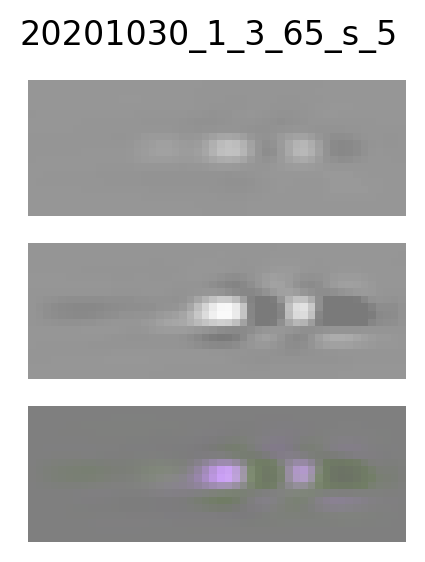

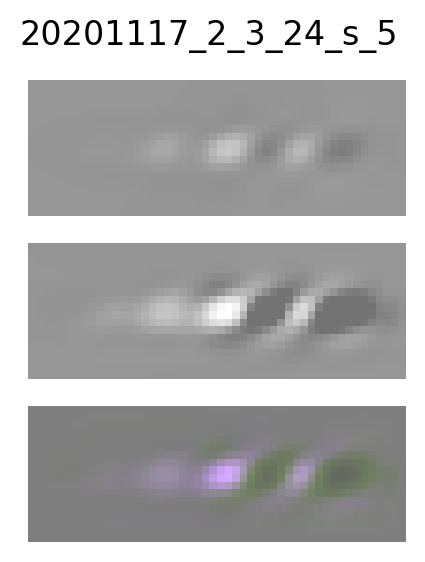

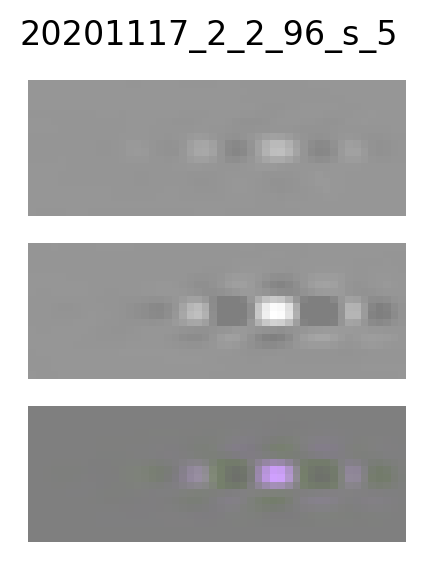

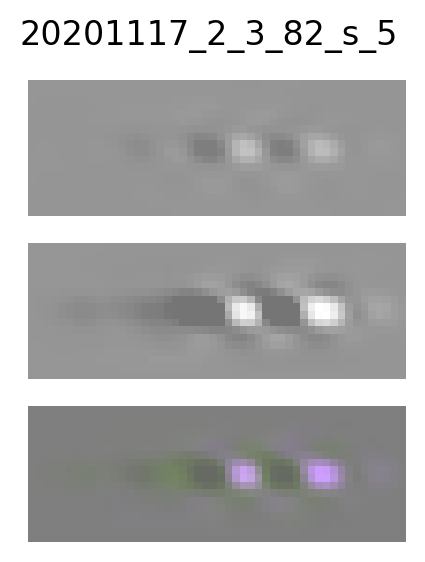

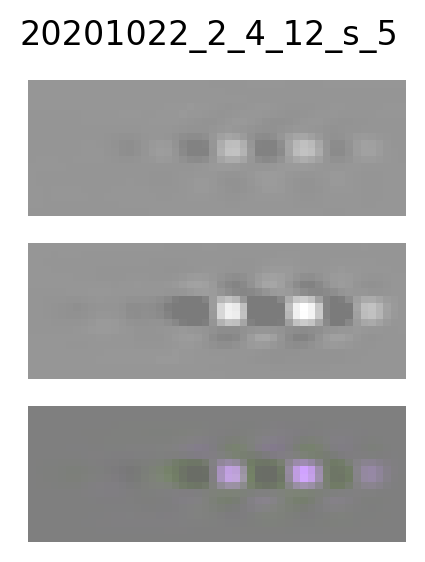

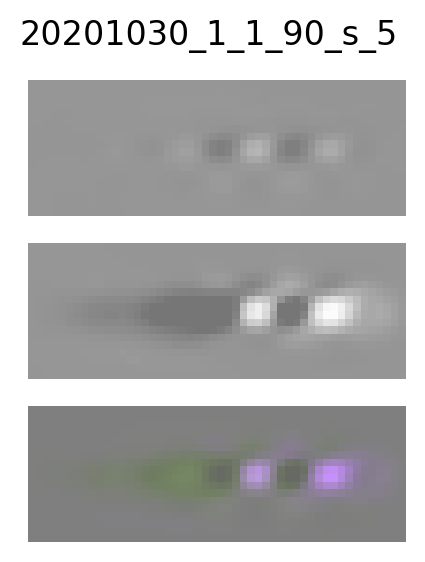

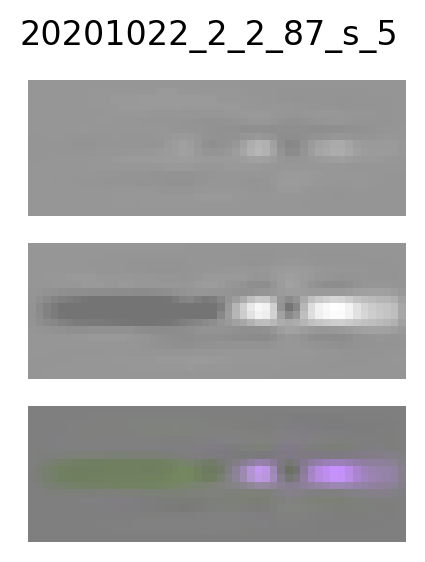

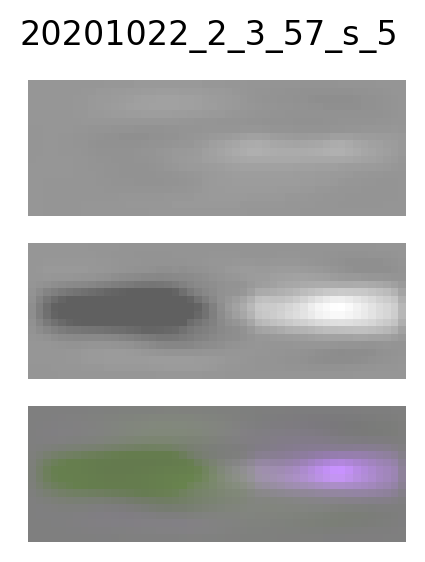

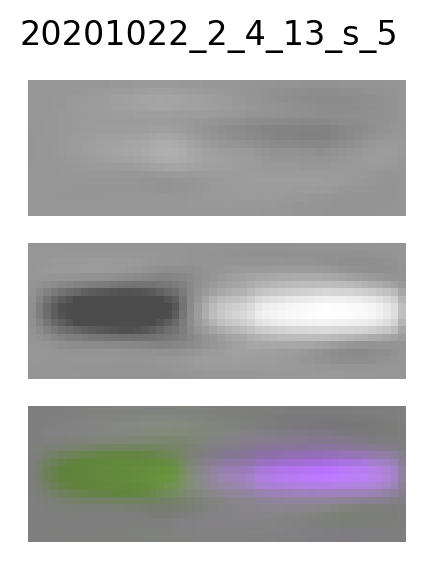

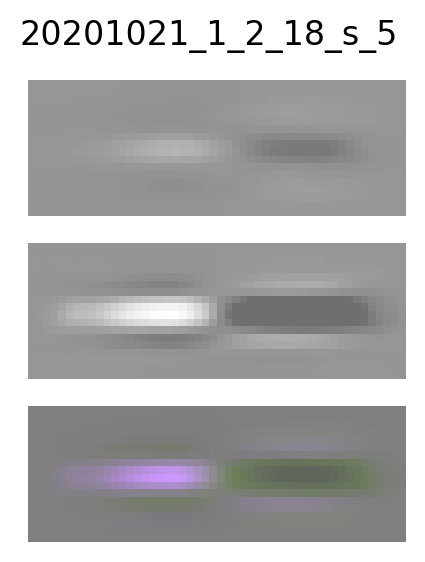

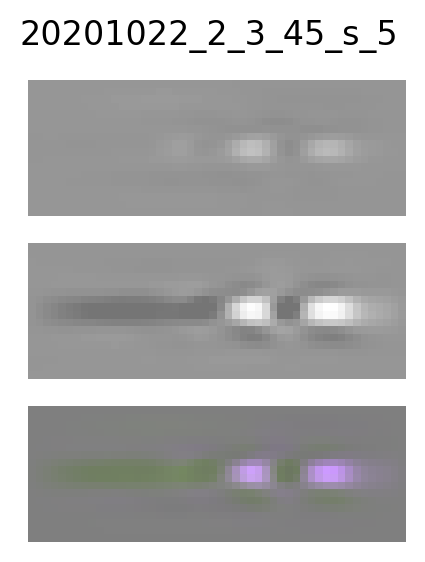

In [19]:
for _, neuron_id, _ in session_id_neuron_id_model_readout_idx_list:
    curr_stimulus = mei_map[neuron_id][0].cpu().numpy()
    fig = space_time_plot(curr_stimulus);
    plt.suptitle(neuron_id)